In [1]:
%matplotlib inline
%matplotlib widget

import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size = 18)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [64]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
try:
    import mpld3
    mpld3.enable_notebook()
    print("Modul mpld3 je instaliran.")
except:
    print("Modul mpld3 nije instaliran.")
    
def plotSpectrum(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    plt.plot(np.fft.fftshift(np.fft.fftfreq(n)),np.fft.fftshift(abs(np.fft.fft(x))));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()
        
def plotSpectrumdB(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    plt.plot(np.fft.fftshift(np.fft.fftfreq(n)),20*np.log10(np.fft.fftshift(abs(np.fft.fft(x)))));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()
    
def stemSpectrum(x, xlabel = "", ylabel="", title="", show=True):
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    plt.stem(F, X)#, use_line_collection=True);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def plotSignal(x, xlabel = "", ylabel="", title="", show=True):
    plt.plot(x);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def stemSignal(x, xlabel = "", ylabel="", title="", show=True):
    plt.stem(x)# ,use_line_collection=True);
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title);
    if show:
        plt.show()

def genTestSpectrum_old(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = round(n*freqStart)
    indEnd = round(n*freqEnd)
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, num=indEnd-indStart) * (ampStart-ampEnd)
    if randPhase:
        x[indStart:indEnd] *= np.exp(1j*2*np.pi*np.random.rand(indEnd-indStart)) # randomize phase
    x[0] = abs(x[1])/2
    timeDomain = np.fft.ifft(x)
    return(timeDomain)

def compressor(x, D):
    # Downsample the signal by factor D
    #   x - input signal
    #   D - downsampling factor
    return x[0::D]

def expander(x, I):
    # Upsample the signal by factor I
    #   x - input signal
    #   I - upsampling factor
    nx = len(x)
    xI = np.zeros(nx*I)
    xI[::I] = x
    return xI

def genTestSpectrum(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = n//2 + round(n*f[0])
    indEnd = n//2 + round(n*f[1])
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, indEnd-indStart) * (ampStart - ampEnd)
    x_new = np.zeros(len(x), dtype=complex)
    x_new[:len(x)//2] = x[len(x)//2:]
    x_new[len(x)//2:] = x[:len(x)//2]
    timeDomain = np.fft.ifft(x_new)
    return timeDomain

def recFunct(N, M, type='nrz'):
    phase = np.random.uniform(-np.pi, np.pi, N)
    Y = np.ones(N, dtype = complex) * np.exp(1j*phase)
    y = np.fft.ifft(Y)

    if type=='nrz':
        rec = np.ones(M) / M
    elif type=='rz':
        rec = np.ones(M) / M
        rec[M//2:] = 0
    elif type=='rf':
        rec = np.ones(M) / M
        rec[M//2:] = -1 / M
    elif type=='rfrz':
        rec = np.ones(M) / M
        rec[M//4:M//2] = -1 / M
        rec[M//2:] = 0
    else:
        print("Error")

    y_rec = signal.lfilter(rec, 1.0, y)
    Y_rec = 20*np.log10(np.absolute(np.fft.fftshift(np.fft.fft(y_rec))))

    return Y_rec

def readSamples(fileName):
    samples = []
    inFile = open(fileName, "r")
    for line in inFile:
        samples.append( complex(line) )
    return np.array(samples)

Modul mpld3 je instaliran.


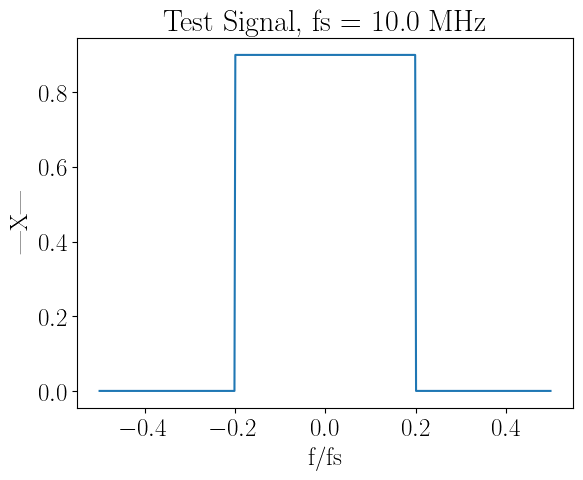

In [90]:
# testsignal = readSamples("testsignal.txt")

N = 1024
f_max = 0.2
f = [-f_max, f_max]
a = [1.0, 0.8]
testSignal = genTestSpectrum(N, f, a, True).real

fs = 10e6
NyqZones = 8 # Width of reconstruction pulse

freqs = (np.arange(N)/N - 0.5)
plt.plot(freqs, np.fft.fftshift(abs(np.fft.fft(testSignal))))
plt.xlabel("f/fs")
plt.ylabel("|X|");
plt.title(f"Test Signal, fs = {fs/1e6} MHz");

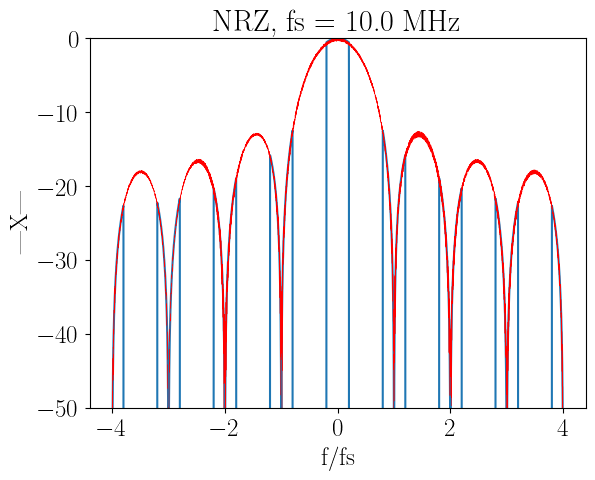

In [95]:
nrz = np.ones(NyqZones)
x_upsampled = np.zeros((len(testSignal)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
x_upsampled[::NyqZones] = testSignal

x_nrz = np.convolve(nrz, x_upsampled)
XnrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_nrz))))
XnrzdB -= np.max(XnrzdB)

Y_nrz = recFunct(len(x_nrz), NyqZones, type='nrz')
Y_nrz -= np.max(Y_nrz)

freqs_nrz = (np.arange(len(x_nrz))/len(x_nrz) - 0.5) * NyqZones

plt.plot(freqs_nrz, XnrzdB, linewidth=1.5)
plt.plot(freqs_nrz, Y_nrz, '-r', linewidth=0.2)
plt.ylim([-50, 0])
plt.ylabel("|X|")
plt.xlabel('f/fs')
plt.title(f'NRZ, fs = {fs/1e6} MHz')
plt.show();

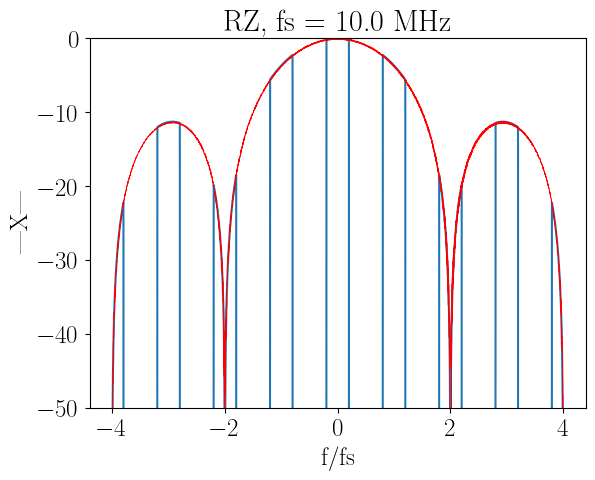

In [96]:
rz = np.ones(NyqZones)
rz[NyqZones//2:] = 0
x_upsampled = np.zeros((len(testSignal)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
x_upsampled[::NyqZones] = testSignal

x_rz = np.convolve(rz, x_upsampled)
XrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_rz))))
XrzdB -= np.max(XrzdB)

Y_rz = recFunct(len(x_rz), NyqZones, type='rz')
Y_rz -= np.max(Y_rz)

freqs_rz = (np.arange(len(x_rz))/len(x_rz) - 0.5) * NyqZones

plt.plot(freqs_rz, XrzdB, linewidth=1.5)
plt.plot(freqs_rz, Y_rz, '-r', linewidth=0.2)
plt.ylim([-50, 0])
plt.ylabel("|X|")
plt.xlabel('f/fs')
plt.title(f'RZ, fs = {fs/1e6} MHz')
plt.show();

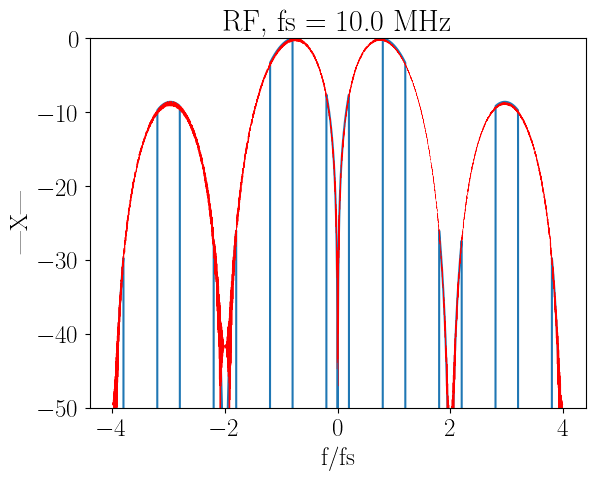

In [97]:
rf = np.ones(NyqZones)
rf[NyqZones//2:] = -1
x_upsampled = np.zeros((len(testSignal)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
x_upsampled[::NyqZones] = testSignal

x_rf = np.convolve(rf, x_upsampled)
XrfdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_rf))))
XrfdB -= np.max(XrfdB)

Y_rf = recFunct(len(x_rf), NyqZones, type='rf')
Y_rf -= np.max(Y_rf)

freqs_rf = (np.arange(len(x_rz))/len(x_rz) - 0.5) * NyqZones

plt.plot(freqs_rf, XrfdB, linewidth=1.5)
plt.plot(freqs_rf, Y_rf, '-r', linewidth=0.2)
plt.ylim([-50, 0])
plt.ylabel("|X|")
plt.xlabel('f/fs')
plt.title(f'RF, fs = {fs/1e6} MHz')
plt.show();

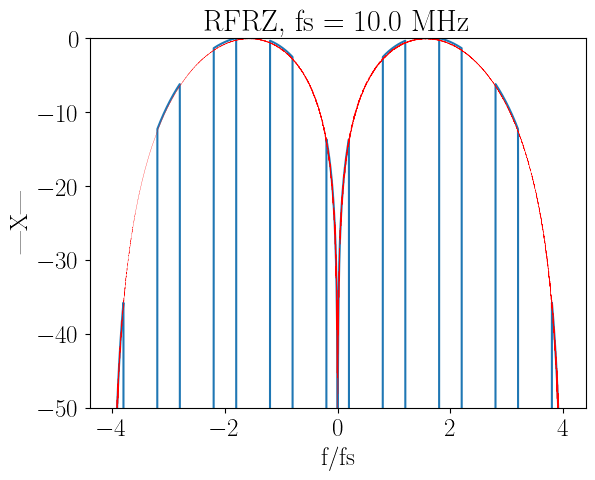

In [99]:
rfrz = np.ones(NyqZones)
rfrz[NyqZones//4:NyqZones//2] = -1
rfrz[NyqZones//2:] = 0
x_upsampled = np.zeros((len(testSignal)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
x_upsampled[::NyqZones] = testSignal

x_rfrz = np.convolve(rfrz, x_upsampled)
XrfrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_rfrz))))
XrfrzdB -= np.max(XrfrzdB)

Y_rfrz = recFunct(len(x_rfrz), NyqZones, type='rfrz')
Y_rfrz -= np.max(Y_rfrz)

freqs_rfrz = (np.arange(len(x_rfrz))/len(x_rfrz) - 0.5) * NyqZones

plt.plot(freqs_rfrz, XrfrzdB, linewidth=1.5)
plt.plot(freqs_rfrz, Y_rfrz, '-r', linewidth=0.2)
plt.ylim([-50, 0])
plt.ylabel("|X|")
plt.xlabel('f/fs')
plt.title(f'RFRZ, fs = {fs/1e6} MHz')
plt.show();

In [ ]:
rfi = np.ones(NyqZones)
rfi[NyqZones//4:NyqZones//2] = 0
rfi[NyqZones//2:3*NyqZones//4] = -1
rfi[3*NyqZones//4:] = 0

rfq = np.ones(NyqZones)
rfq[:NyqZones//4] = 0
rfq[NyqZones//2:3*NyqZones//4] = 0
rfq[3*NyqZones//4:] = -1


# Pitati

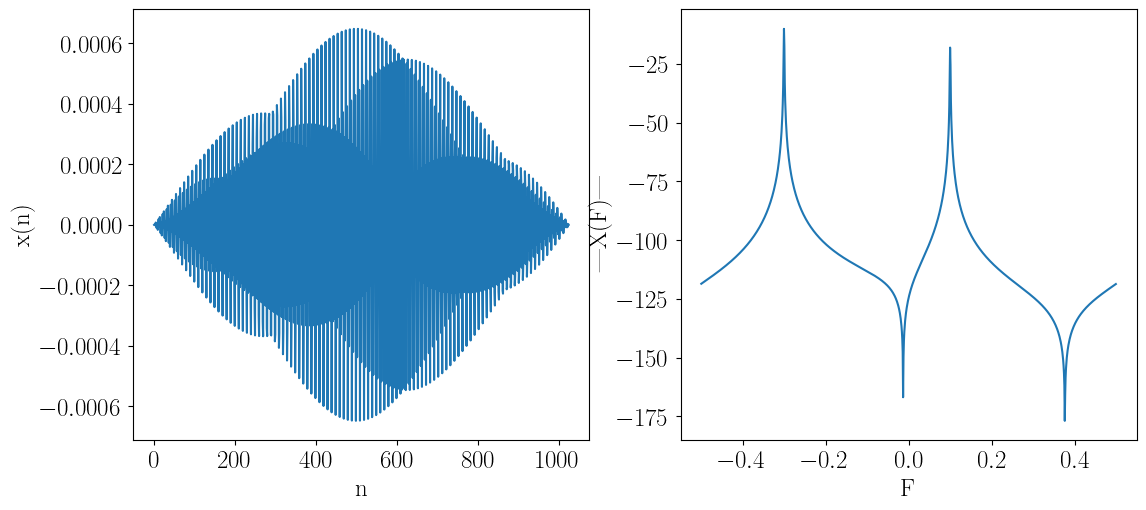

In [7]:
N = 1024
f_max = 0.2
f = [-f_max, f_max]
a = [1.0, 0.4]
x = genTestSpectrum(N, f, a, True)

Omega0 = 2*np.pi*f_max/2
n = np.arange(len(x))
cplx_sine = np.exp(1j*n*(-Omega0))
x_shifted = x * cplx_sine

win = signal.hann(len(x_shifted), False)
# x_shifted *= win
x_shifted_r = x_shifted.real*win
x_shifted_i = x_shifted.imag*win
x_shifted = x_shifted_r + 1j*x_shifted_i
                         
figH = 4
plt.subplots(1,2,figsize=(2*1.618*figH,1.4*figH))
plt.subplot(1,2,1)
plotSignal(x_shifted, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plotSpectrumdB(x_shifted, 'F', '|X(F)|')

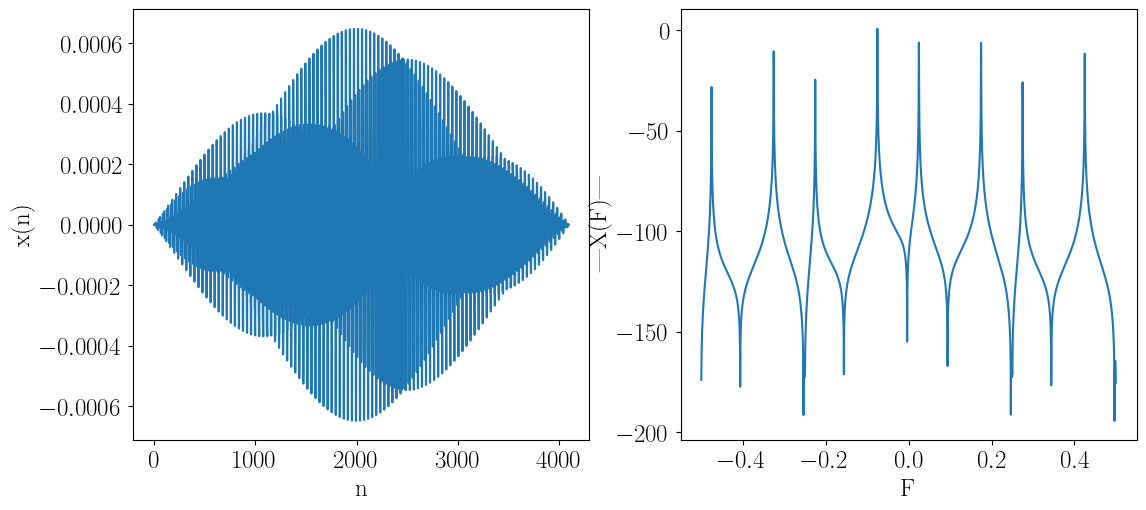

In [8]:
M = 4
nrz = np.ones(M, dtype = complex)
x_upsampled = np.zeros((len(x_shifted)-1)*M+1, dtype = complex)
x_upsampled[::M] = x_shifted

x_nrz = np.convolve(x_upsampled, nrz)

figH = 4
plt.subplots(1,2,figsize=(2*1.618*figH,1.4*figH))
plt.subplot(1,2,1)
plotSignal(x_nrz, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plotSpectrumdB(x_nrz, 'F', '|X(F)|')

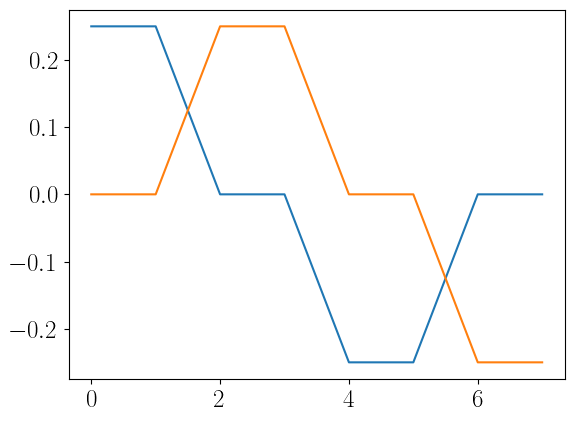

In [9]:
M = 8
rfi = np.ones(M) / (M/2)
rfi[M//4:M//2] = 0
rfi[M//2:3*M//4] = -1 / (M/2)
rfi[3*M//4:] = 0
rfq = np.ones(M) / (M/2)
rfq[:M//4] = 0
rfq[M//2:3*M//4]=0
rfq[3*M//4:] = -1 / (M/2)

plt.plot(rfi)
plt.plot(rfq)

In [10]:
x_rfi = signal.lfilter(rfi, 1, x.real)
x_rfq = signal.lfilter(rfq, 1, x.imag)
x_rfiq = x_rfi + x_rfq
# x_rfiq = 2*x_rfiq.real

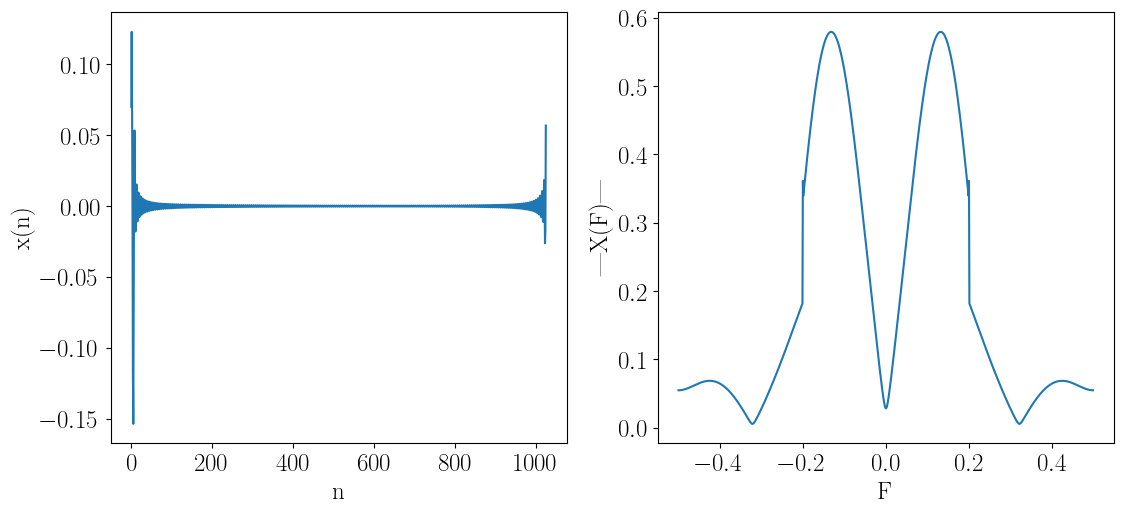

In [11]:
figH = 4
plt.subplots(1,2,figsize=(2*1.618*figH,1.4*figH))
plt.subplot(1,2,1)
plotSignal(x_rfiq, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plotSpectrum(x_rfiq, 'F', '|X(F)|')

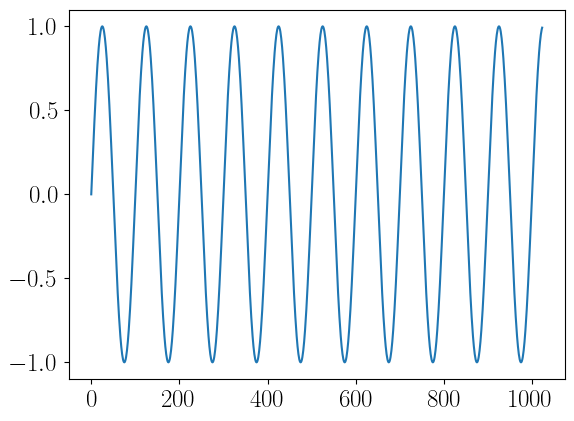

In [12]:
N = 1024
n = np.arange(N)
f = 10
fs = 1e3
T = 1/fs

x = np.sin(2*np.pi*n*f/fs) 

plt.plot(x)

In [13]:
M = 4
nrz = np.ones(M, dtype = complex)
rz = np.ones(M)
rz[M//2:] = 0

x_upsampled = np.zeros((len(x)-1)*M+1, dtype = complex)
x_upsampled[::M] = x

x_nrz = np.convolve(nrz, x_upsampled)
x_rz = np.convolve(rz, x_upsampled)
# x_nrz = signal.lfilter(nrz, 1, x_upsampled)
# x_rz = signal.lfilter(rz, 1, x_upsampled) 

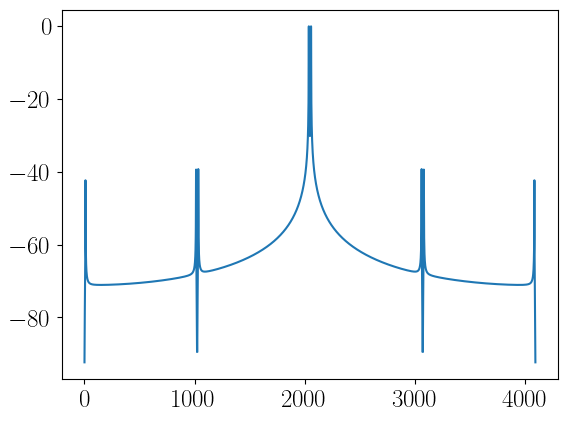

In [14]:
XnrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_nrz))))
# freqs_nrz = (np.arange(N*M*len(nrz))/(N*M*len(nrz)) - 0.5) * M*fs*len(nrz)/1e6
plt.plot(XnrzdB-np.max(XnrzdB))
# plt.plot(XrdB-np.max(XrdB),'r')

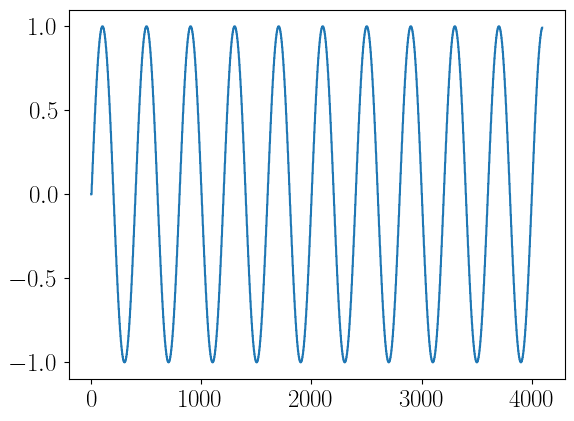

In [15]:
plt.plot(x_nrz)
# plt.plot(x)

In [ ]:
plt.plot(x_rz)
plt.plot(x)

In [ ]:
f = [-0.1, 0.1]
n = 1024
ampl = [1.0, 0.8]

ampStart = ampl[0]
ampEnd = ampl[1]

x = np.zeros(n, dtype = complex)
indStart = n//2 + round(n*f[0])
indEnd = n//2 + round(n*f[1])
x[indStart:indEnd] = ampStart - np.linspace(0, 1, indEnd-indStart) * (ampStart - ampEnd)
x_new = np.zeros(len(x), dtype=complex)
x_new[:len(x)//2] = x[len(x)//2:]
x_new[len(x)//2:] = x[:len(x)//2]


timeDomain = np.fft.ifft(x_new)

freqs = np.arange(n) / n - 0.5

plt.plot(freqs, x_new)

In [ ]:
y = np.fft.fftshift(abs(np.fft.fft(timeDomain)))

In [ ]:
plt.plot(y)